# Dataset and DataLoder

处理数据样本的代码可能会变得混乱且难以维护；理想情况下是希望数据集代码与模型训练代码分离，以提升可读性和模块化性。PyTorch 提供了两个数据原语：`torch.utils.data.DataLoader` 和 `torch.utils.data.Dataset`，它们允许你使用预加载的数据集以及自己的数据。Dataset 存储样本及其对应的标签，而 DataLoader 包装了一个可迭代对象，使得样本可以轻松访问。

![Dataset and Dataloder](https://drek4537l1klr.cloudfront.net/stevens2/Figures/CH07_F14_Stevens2_GS.png)

简单来说，Dataset可以加载pytorch内置的数据集，也可以自定义数据加载和预处理方式获取数据集，而Dataloder则是对数据集进行**自定义处理分成特定的batch数据**，用来作为模型的输入。

## 一. Dataset

### 1.1 内置的数据集

PyTorch 领域库提供了许多预加载的数据集（如 FashionMNIST），它们是 `torch.utils.data.Dataset` 的子类，并实现了特定于特定数据的函数。它们可用于原型设计和模型基准测试。你可以在以下位置找到它们：图像数据集、文本数据集和音频数据集。
下面是一个如何从 TorchVision 加载 Fashion-MNIST 数据集的示例。Fashion-MNIST 是一个包含 Zalando 服饰图像的数据集，包括 60,000 个训练样本和 10,000 个测试样本。每个样本包括一个 28×28 的灰度图像以及一个来自 10 个类别中的相关标签。

我们使用以下参数加载 FashionMNIST 数据集：

- `root` 是存储训练/测试数据的路径，
- `train` 指定是训练集还是测试集，
- `download=True` 表示如果数据在 `root` 路径中不可用，则从互联网上下载数据，
- `transform` 和 `target_transform` 指定对特征和标签的转换。


In [22]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

遍历和可视化数据集

我们可以像列表一样手动索引数据集：`training_data[index]`。我们使用 matplotlib 来可视化训练数据中的一些样本。

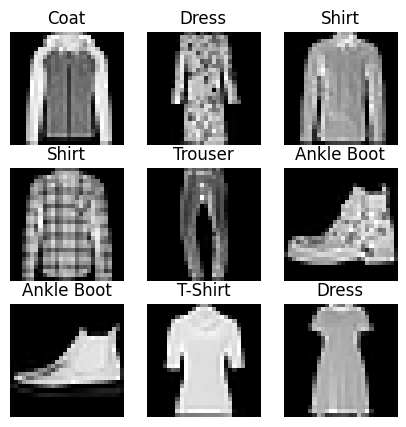

In [23]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(5, 5))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### 1.2 自定义Dataset数据集

Dataset是一个抽象类，为了创建自定义数据集，需要继承 torch.utils.data.Dataset 类并实现以下方法：
- `__init__`：初始化，可以保存读取路径、直接输入训练数据和标签，也可以输入函数，通过函数获取训练数据和标签，总之灵活多样。
- `__len__`：返回数据集的大小，源代码中虽然没要强制重写，但是DataLoader会使用，所以官方建议重写。
- `__getitem__`：根据索引返回数据集中的**一个样本**，DataLoader会产生一个batchsize的索引列表，根据列表里索引，不断迭代调用`__getitem__`函数，实现读取整个batchsize的数据。


In [6]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### 1.3 流式 (Iterable) Dataset
Iterable 数据集适用于不能随机访问数据的场景，如从数据库或网络流中获取数据。

**特点**：
- 适用于需要从源头顺序读取数据的场景。
- 无法预先知道数据集的大小。

示例：

In [7]:
import torch
from torch.utils.data import IterableDataset

class StreamDataset(IterableDataset):
    def __init__(self, data_source):
        self.data_source = data_source

    def __iter__(self):
        for data in self.data_source:
            yield data


## 二. DataLoader

Dataloader将数据集和采样器结合起来，并提供一个可迭代的数据集。

`torch.utils.data.DataLoader`支持**映射式（Map-Style, 即Dataset）和可迭代式（IterableDataset）**的数据集，支持单进程或多进程加载、定制加载顺序、自动批处理（collation）和内存固定。


参数:
+ **`dataset (Dataset):`** 数据加载来源的数据集。

- **`batch_size (int, optional):`** 每个批次加载的样本数量（默认：`1`）。
+ **`shuffle (bool, optional):`** 每个 epoch 是否重新打乱数据的顺序（默认：``False``）。

- **`sampler (Sampler or Iterable, optional):`** 定义从数据集中抽取样本的策略。可以是任何实现了 `__len__` 的 `Iterable`。如果指定了该参数，则不能指定 `shuffle`。

+ **`batch_sampler (Sampler or Iterable, optional):`** 类似于 :attr:`sampler`，但一次返回一批索引。与 `batch_size`、`shuffle`、`sampler` 和 `drop_last` 互斥。

- **`num_workers (int, optional):`** 用于数据加载的子进程数量。``0`` 表示数据将在主进程中加载（默认：``0``）。

+ **`collate_fn (callable, optional):`** 将样本列表合并形成小批量的 Tensor(s),用于映射式数据集的批量加载。输入是batch输出也是一个batch。

- `pin_memory (bool, optional)`: 如果为 `True`，数据加载器会在返回前将 Tensors 复制到设备/CUDA 固定内存中。如果数据元素是自定义类型，或者 `collate_fn` 返回的是自定义类型的批次，请参阅下面的示例。

+ `drop_last (bool, optional):` 如果数据集大小不能被批次大小整除，设置为 ``True`` 将丢弃最后一个不完整的批次。如果为 ``False``，数据集大小不能被批次大小整除，则最后一个批次将会较小（默认：``False``）。

- `timeout (numeric, optional):` 如果为正数，则为从工作进程收集批次的超时时间。应始终为非负数（默认：``0``）。

+ `worker_init_fn (callable, optional):` 如果不是 ``None``，则在每个工作子进程上调用此函数，并传入工作 ID（在 ``[0, num_workers - 1]`` 范围内的整数）作为输入，在种子设定和数据加载之前调用（默认：``None``）。

- `generator (torch.Generator, optional):` 如果不是 ``None``，则由 RandomSampler 使用此 RNG 生成随机索引，并由多进程生成工作进程的 `base_seed`（默认：``None``）。

+ `prefetch_factor (int, optional, keyword-only arg):` 每个工作进程提前加载的批次数量。``2`` 表示所有工作进程预取总共 2 * num_workers 批次（默认：``2``）。

- `persistent_workers (bool, optional):` 如果为 ``True``，数据加载器在消耗完一个数据集后不会关闭工作进程。这允许保持工作进程的 `Dataset` 实例（默认：``False``）。

+ `pin_memory_device (str, optional):` 如果 `pin_memory` 设置为 True，数据加载器将在返回前将 Tensors 复制到设备固定内存中。


Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


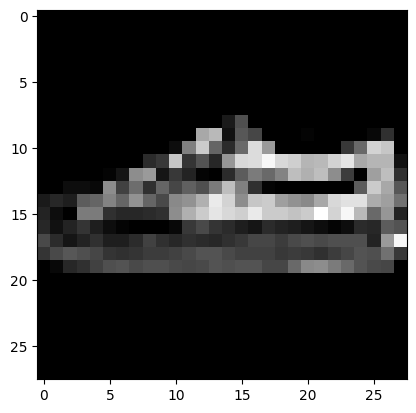

Label: 7


In [11]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## 三. 详解一个batch的产生


### 3.1 可迭代对象、迭代器和生成器

**`DataLader:`实际上可以认为是一个可迭代对象，只不过在迭代时候可以返回`batchsize`大小的训练样本。**
![可迭代对象和迭代器](https://miro.medium.com/v2/resize:fit:828/format:webp/0*3-Pds8MFCSFYwxkY.png)

+ 可迭代对象（iterable）：实现了`__iter__ `方法，**该方法返回一个迭代器对象**；
- 迭代器（iterator）:迭代器含有`__iter__`和`__next__`方法，当调用 `__iter__` 返回迭代器自身，当调用`next()`方法返回容器下一个值；
+ 二者关系：使用 iter将可迭代对象转换为迭代器.
- 生成器：是一种特殊的迭代器，**它允许你在函数执行过程中保存函数的状态**，并能够在后续的调用中从上次停止的地方继续执行，而不需要从头开始执行整个函数。下面代码是分别通过**yield关键字和生成器表达式**来定义一个生成器：

In [33]:
print('使用yield关键字:')  
def count_up_to(max):
    count = 0
    for i in range(max):
        yield count * count
        count += 1
for i in count_up_to(5):
    print(i)
print('\n使用生成器表达式:')  
squares = (x * x for x in range(5))
for i in squares:
    print(i)

使用yield关键字
0
1
4
9
16

使用生成器表达式
0
1
4
9
16



### 3.2 一个batch样本加载的详细流程及源码解析

![一个batch样本加载的详细流程](http://andy-blog.oss-cn-beijing.aliyuncs.com/blog/2020-12-11-WX20201211-184043%402x.png)

### 1.读哪些？
读哪些数据是通过index来获取，这面临两个问题，一是对整个`dataset`数据集如何进行index排序，这通过`samper`来实现；另一个问题是获取索引排序后，如何对索引进行分组，使得每次循环只输出`batchsize`大小的数据，这通过`batchsamper`来实现。

总之，`DataLoader` 的批次处理是通过 `BatchSampler` 完成的，而 `BatchSampler` 是基于 `Sampler` 的。因此，每次 `DataLoader` 被调用时，都会首先调用 `Sampler` 来生成索引，然后通过 `BatchSampler` 将这些索引分成批次。
### Samper：定义整个数据集索引index返回顺序策略

`Sampler` 是 PyTorch 中用于定义数据集样本抽取策略的抽象基类。它决定了数据加载器如何遍历数据集，从而影响数据的抽取顺序。`Sampler` 主要有两种用途：
1. **控制数据的抽取顺序**，例如按顺序、随机、分层或任何其他定制策略。
2. **控制哪些样本被抽取**，例如在交叉验证中只抽取训练集或验证集样本。

`torch.utils.data.Sampler` 是所有 `Sampler` 类的基础，它要求子类实现两个方法：
- `__iter__():` 返回一个迭代器，用于生成数据集中的样本索引。
- `__len__():` 返回迭代器中产生的索引总数。

**默认的 `Sampler` 类型**
+ `SequentialSampler:`这是最简单的 Sampler，它按照数据集中的顺序遍历所有样本。等同于 `shuffle=False`。
- `RandomSampler:`它以随机顺序遍历数据集。等同于 `shuffle=True`。

**自定义 Sampler 示例**

使用 PyTorch 自定义一个 Sampler 来确保在每个 epoch 中模型都能根据类别权重获取每个类别对应的样本。
以下是代码示例及其中文注释：

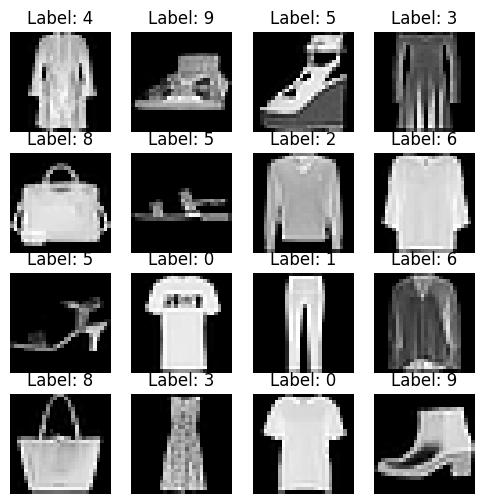

In [36]:
import torch
from torch.utils.data import Dataset, DataLoader, Sampler
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# 定义自定义数据集示例
class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

# 定义自定义采样器
class WeightedSampler(Sampler):
    def __init__(self, data_source, class_weights):
        self.data_source = data_source
        self.class_weights = class_weights
        self.class_indices = self._get_class_indices()

    def _get_class_indices(self):
        # 获取每个类别对应的样本索引
        class_indices = {}
        for idx, (_, target) in enumerate(self.data_source):
            if target not in class_indices:
                class_indices[target] = []
            class_indices[target].append(idx)
        return class_indices

    def __iter__(self):
        # 根据类别权重生成采样索引
        indices = []
        for class_label, weight in self.class_weights.items():
            indices.extend(np.random.choice(self.class_indices[class_label], int(len(self.data_source) * weight), replace=True))
        np.random.shuffle(indices)
        return iter(indices)

    def __len__(self):
        return len(self.data_source)

# 加载FashionMNIST数据集
transform = transforms.Compose([transforms.ToTensor()])
fashion_mnist = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# 获取数据和标签
data = fashion_mnist.data.numpy()
targets = fashion_mnist.targets.numpy()

# 定义类别权重
class_weights = {i: 1/10 for i in range(10)}  # 假设每个类别权重相同

# 创建自定义数据集和采样器
dataset = MyDataset(data, targets)
sampler = WeightedSampler(dataset, class_weights)

# 创建DataLoader
dataloader = DataLoader(dataset, batch_size=16, sampler=sampler)

# 可视化部分样本
def show_images(images, labels):
    plt.figure(figsize=(6, 6))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

# 从DataLoader中获取一个批次的数据
images, labels = next(iter(dataloader))
images = images.numpy()
show_images(images, labels)


### BactchSamper：将Samper返回的样本索引按批次大小分组。
参数:
- `sampler:` 一个 `Sampler` 实例，负责生成单个样本的索引。
- `batch_size:` 每个批次的大小，即每次 yield 的索引数量。
- `drop_last:` 如果为 `True`，当数据集的大小不能被批次大小整除时，丢弃最后一个不完整的批次；如果为 `False`，则返回最后一个不完整的批次。

方法:
- `iter:` 生成批次索引的迭代器。它会不断从 `sampler` 中获取索引，并将它们按批次大小分组，直到生成完所有的索引。
- `len:` 返回批次的数量。根据 `drop_last` 参数的值，计算批次数量时是否考虑最后一个不完整的批次。


In [38]:
class BatchSampler(Sampler):
    def __init__(self, sampler, batch_size, drop_last):
        self.sampler = sampler
        self.batch_size = batch_size
        self.drop_last = drop_last

    def __iter__(self):
        batch = []
        for idx in self.sampler:
            batch.append(idx)
            if len(batch) == self.batch_size:
                yield batch
                batch = []
        if len(batch) > 0 and not self.drop_last:
            yield batch

    def __len__(self):
        if self.drop_last:
            return len(self.sampler) // self.batch_size
        else:
            return (len(self.sampler) + self.batch_size - 1) // self.batch_size


### 源码解析一个batch的index是怎么来的
对dataloader进行遍历的时候，会调用`__iter__`函数，**以单线程读取数据源代码为例进行讲解**：
```python
 def __iter__(self) -> '_BaseDataLoaderIter':
        if self.persistent_workers and self.num_workers > 0:
            if self._iterator is None:
                self._iterator = self._get_iterator()
            else:
                self._iterator._reset(self)
            return self._iterator
        else:
            **只关注这里**
            return self._get_iterator()
```
返回一个`self._get_iterator()`,下面看下这个

```python
    def _get_iterator(self) -> '_BaseDataLoaderIter':
        if self.num_workers == 0:
            **单线程为例**
            return _SingleProcessDataLoaderIter(self)
        else:
            self.check_worker_number_rationality()
            return _MultiProcessingDataLoaderIter(self)
```
看下`_SingleProcessDataLoaderIter(self)`源代码：
```python
class _SingleProcessDataLoaderIter(_BaseDataLoaderIter):
    def __init__(self, loader):
        ......
        
        self._dataset_fetcher = _DatasetKind.create_fetcher(
            self._dataset_kind, self._dataset, self._auto_collation, self._collate_fn, self._drop_last) 

    def _next_data(self):
        **获取index**
        index = self._next_index()  # may raise StopIteration
        data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
        if self._pin_memory:
            data = _utils.pin_memory.pin_memory(data, self._pin_memory_device)
        return data

``` 
`self._next_index()`是怎么运行的，可以看源代码:
```python
    def _next_index(self):
        return next(self._sampler_iter)  # may raise StopIteration

```
`self._sampler_iter`源代码:
```python
self._sampler_iter = iter(self._index_sampler)
```
`self._index_sampler`源代码 :   
```python
    @property
    def _index_sampler(self):
        # The actual sampler used for generating indices for `_DatasetFetcher`
        # (see _utils/fetch.py) to read data at each time. This would be
        # `.batch_sampler` if in auto-collation mode, and `.sampler` otherwise.
        # We can't change `.sampler` and `.batch_sampler` attributes for BC
        # reasons.
        if self._auto_collation:
            return self.batch_sampler
        else:
            return self.sampler
```
最后获取`self.batch_sampler`，下面是`batch_sampler`的组成逻辑
```python
def __init__(...):
    ......
        if sampler is None:  # give default samplers
            if self._dataset_kind == _DatasetKind.Iterable:
                # See NOTE [ Custom Samplers and IterableDataset ]
                sampler = _InfiniteConstantSampler()
            else:  # map-style
                if shuffle:
                    sampler = RandomSampler(dataset, generator=generator)  # type: ignore[arg-type]
                else:
                    sampler = SequentialSampler(dataset)  # type: ignore[arg-type]

        if batch_size is not None and batch_sampler is None:
            # auto_collation without custom batch_sampler
            batch_sampler = BatchSampler(sampler, batch_size, drop_last)

        self.batch_size = batch_size
        self.drop_last = drop_last
        self.sampler = sampler
        self.batch_sampler = batch_sampler
    ......
```
**特别注意!!!**

当你在 `DataLoader` 中指定 `batch_sampler` 时，`DataLoader` 会直接使用 `batch_sampler` 来生成批次的索引，而不会再使用给定的 `sampler`。如果你只指定了 `sampler`，`DataLoader` 会使用 `sampler` 生成单个样本的索引，然后根据 `batch_size` 将这些索引组合成批次。
**为什么会这样？可以看下上面这个源代码，逻辑是不指定`batch_sampler`，会使用默认的`batch_sampler`，默认的`batch_sampler`使用给定的`samper`或通过`shuffle`控制的RandomSampler（SequentialSampler）**

+ `dataloader = DataLoader(dataset, samper = samper，batch_sampler=batch_sampler)`,**这个用法是错误的**

+ `dataloader = DataLoader(dataset, sampler=sampler, batch_size=4)`,**用法正确，可以自定义samper**
+ `batch_sampler = BatchSampler(RandomSampler(dataset), batch_size=4, drop_last=False)`
+ `dataloader = DataLoader(dataset, batch_sampler=batch_sampler)`**用法正确，可以自定义samper和batch_samper**


### 2.从哪读？和3.怎么读？
### DatasetFetcher：根据上述批次索引从Dataset中提取数据并进行批次处理
从哪读和怎么读这个问题是通过`DatasetFetcher`来实现的，首先需要创建一个提取器`create_fetcher`，然后提取器根据`index`提取数据，下面**以单线程读取数据源代码为例进行讲解**：
```python
class _SingleProcessDataLoaderIter(_BaseDataLoaderIter):
    def __init__(self, loader):
        ......
        **创建一个提取器**
        self._dataset_fetcher = _DatasetKind.create_fetcher(
            self._dataset_kind, self._dataset, self._auto_collation, self._collate_fn, self._drop_last) 

    def _next_data(self):
        index = self._next_index()  # may raise StopIteration
        **根据index提取数据**
        data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
        if self._pin_memory:
            data = _utils.pin_memory.pin_memory(data, self._pin_memory_device)
        return data
``` 
`_DatasetKind.create_fetcher`源代码
```python
class _DatasetKind:
    Map = 0
    Iterable = 1

    @staticmethod
    def create_fetcher(kind, dataset, auto_collation, collate_fn, drop_last):
        if kind == _DatasetKind.Map:
            return _utils.fetch._MapDatasetFetcher(dataset, auto_collation, collate_fn, drop_last)
        else:
            return _utils.fetch._IterableDatasetFetcher(dataset, auto_collation, collate_fn, drop_last)
```
如源代码所示，创建一个提取器，需要输入数据集的类型、数据集、`auto_collation`（自动拼接），`collate_fn`(如何批次进行组合)、`drop_last`.
创建完成提取器需要按着`index`进行提取，使用`self._dataset_fetcher.fetch(index)`，下面看下`fetch`的源代码：
```python
class _MapDatasetFetcher(_BaseDatasetFetcher):
    def fetch(self, possibly_batched_index):
        if self.auto_collation:
            if hasattr(self.dataset, "__getitems__") and self.dataset.__getitems__:
                data = self.dataset.__getitems__(possibly_batched_index)
            else:
                data = [self.dataset[idx] for idx in possibly_batched_index]
        else:
            data = self.dataset[possibly_batched_index]
        return self.collate_fn(data)
```
是不是很简单，就是迭代索引获取数据，但是需要注意，我们最后返回的不是`data`而是`self.collate_fn(data)`,下面介绍下`collate_fn`

### collate_fn
`collate_fn` 的主要作用是将一个批次的数据进行处理和打包，以便后续训练或推理时使用。它通常用于以下情况：
1. 将多个样本合并成一个批次：这包括将多个样本的张量拼接成一个大张量。
2. 处理不同长度的序列：在自然语言处理等任务中，不同样本的序列长度可能不同，collate_fn 可以用于将它们填充到相同长度。
3. 应用自定义的数据处理逻辑：例如，处理复杂的数据结构或进行特定的预处理步骤。

如果果没有提供自定义的 `collate_fn`，`DataLoader` 会使用默认的 `default_collate` 函数。

**`default_collate`:**

torch.utils.data._utils.collate.default_collate。默认的 collate_fn 处理常见的数据类型，如张量、数字、字符串、字典和元组，下面是处理逻辑：

1. **张量**：如果所有样本都是张量，则它们会被堆叠成一个新的维度。
2. **数字**：如果所有样本都是数字，则它们会被转换为张量。
3. **字符串**：如果所有样本都是字符串，则它们会被直接放入列表中。
4. **字典**：如果样本是字典，则会递归调用 default_collate，以确保字典中的每个键对应的值都被正确处理。
5. **其他类型**：其他类型的数据会被放入列表中。